## ERA5 to HEALPix to Zarr (One-Day Walkthrough)

This notebook is a **conceptual and practical walkthrough** of Homework 2.

We do everything for **one single day (2024-12-01)**:
1. Download ERA5 specific humidity
2. Load and inspect the data
3. Convert from lat–lon grid to HEALPix (NSIDE=8 and 16)
4. Store results in Zarr
5. Load back and plot

This notebook is **not** the final pipeline.
It exists so I understand what is happening.


In [1]:
# Core numerical & data handling
import numpy as np
import xarray as xr

# Plotting
import matplotlib.pyplot as plt

# ERA5 download
import cdsapi

# HEALPix (astropy implementation)
from astropy_healpix import HEALPix
from astropy import units as u

# Convenience
from pathlib import Path


In [2]:
# Output directories
DATA_DIR = Path("data")
PLOTS_DIR = Path("plots")

DATA_DIR.mkdir(exist_ok=True)
PLOTS_DIR.mkdir(exist_ok=True)

# One test day
YEAR = "2024"
MONTH = "12"
DAY = "01"

# Pressure level to inspect (hPa)
LEVEL = 800


In [3]:
c = cdsapi.Client()

outfile = DATA_DIR / f"era5_{YEAR}{MONTH}{DAY}.nc"

if not outfile.exists():
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": "specific_humidity",
            "pressure_level": ["975", "900", "800", "500", "300"],
            "year": YEAR,
            "month": MONTH,
            "day": DAY,
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(outfile)
    )
else:
    print("ERA5 file already exists")


2026-01-19 12:07:20,160 INFO Request ID is b7c30a28-841b-4956-b0ec-9af69df57117
2026-01-19 12:07:20,378 INFO status has been updated to accepted
2026-01-19 12:07:29,607 INFO status has been updated to running
2026-01-19 12:07:34,883 INFO status has been updated to successful


c73f4574cd85790106f4f8645e9ad29a.nc:   0%|          | 0.00/33.2M [00:00<?, ?B/s]

In [4]:
ds = xr.open_dataset(outfile)
ds

<xarray.Dataset> Size: 83MB
Dimensions:         (valid_time: 4, pressure_level: 5, latitude: 721,
                     longitude: 1440)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 32B 2024-12-01 ... 2024-12-01...
  * pressure_level  (pressure_level) float64 40B 975.0 900.0 800.0 500.0 300.0
  * latitude        (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude       (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    expver          (valid_time) <U4 64B ...
Data variables:
    q               (valid_time, pressure_level, latitude, longitude) float32 83MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-16T09:30 GRIB to CDM+CF via cfgrib-0.9.1...

In [8]:
da = ds["q"].sel(
    valid_time=ds.valid_time[0],
    pressure_level=LEVEL
)

da


<xarray.DataArray 'q' (latitude: 721, longitude: 1440)> Size: 4MB
[1038240 values with dtype=float32]
Coordinates:
    number          int64 8B ...
    valid_time      datetime64[ns] 8B 2024-12-01
    pressure_level  float64 8B 800.0
  * latitude        (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude       (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    expver          <U4 16B ...
Attributes: (12/31)
    GRIB_paramId:                             133
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           q
    GRIB_totalNumber:                         0
    GRIB_units:                               kg kg**-1
    long_name:                                Specific humidity
    units:                                    kg kg**-1
    standard_name:                            specific_humidity

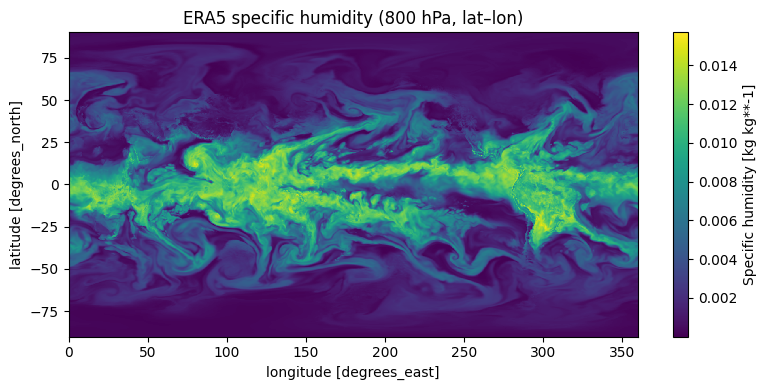

In [9]:
plt.figure(figsize=(8, 4))
da.plot(cmap="viridis")
plt.title(f"ERA5 specific humidity ({LEVEL} hPa, lat–lon)")
plt.tight_layout()
plt.show()

In [10]:
# Latitude / longitude arrays
lats = da.latitude.values
lons = da.longitude.values

# Create 2D grids
lon2d, lat2d = np.meshgrid(lons, lats)

# Convert to astropy units
lon_u = lon2d * u.deg
lat_u = lat2d * u.deg


In [11]:
hp8 = HEALPix(nside=8, order="ring", frame="icrs")

# Convert lon/lat → HEALPix indices
pix8 = hp8.lonlat_to_healpix(lon_u, lat_u)

# Flatten for aggregation
pix8_flat = pix8.flatten()
values_flat = da.values.flatten()

# Prepare output array
hp8_map = np.full(hp8.npix, np.nan)

for p in np.unique(pix8_flat):
    hp8_map[p] = np.nanmean(values_flat[pix8_flat == p])


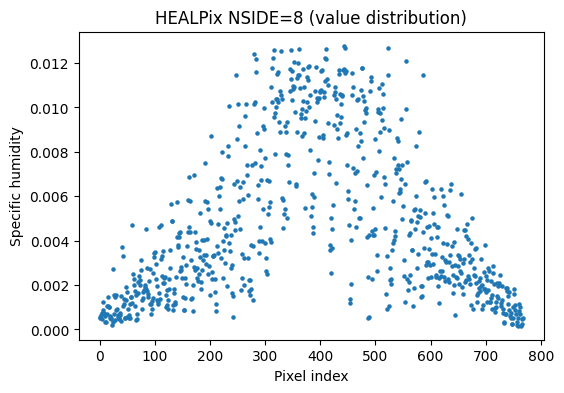

In [12]:
plt.figure(figsize=(6, 4))
plt.scatter(
    np.arange(hp8.npix),
    hp8_map,
    s=5
)
plt.title("HEALPix NSIDE=8 (value distribution)")
plt.xlabel("Pixel index")
plt.ylabel("Specific humidity")
plt.show()


In [13]:
hp16 = HEALPix(nside=16, order="ring", frame="icrs")

pix16 = hp16.lonlat_to_healpix(lon_u, lat_u)
pix16_flat = pix16.flatten()

hp16_map = np.full(hp16.npix, np.nan)

for p in np.unique(pix16_flat):
    hp16_map[p] = np.nanmean(values_flat[pix16_flat == p])


In [14]:
ds_hp8 = xr.Dataset(
    {"specific_humidity": ("healpix", hp8_map)},
    coords={"healpix": np.arange(hp8.npix)},
    attrs={"nside": 8}
)

ds_hp16 = xr.Dataset(
    {"specific_humidity": ("healpix", hp16_map)},
    coords={"healpix": np.arange(hp16.npix)},
    attrs={"nside": 16}
)

ds_hp8, ds_hp16


(<xarray.Dataset> Size: 12kB
 Dimensions:            (healpix: 768)
 Coordinates:
   * healpix            (healpix) int64 6kB 0 1 2 3 4 5 ... 763 764 765 766 767
 Data variables:
     specific_humidity  (healpix) float64 6kB 0.0005192 0.0005505 ... 0.0005067
 Attributes:
     nside:    8,
 <xarray.Dataset> Size: 49kB
 Dimensions:            (healpix: 3072)
 Coordinates:
   * healpix            (healpix) int64 25kB 0 1 2 3 4 ... 3068 3069 3070 3071
 Data variables:
     specific_humidity  (healpix) float64 25kB 0.000505 0.0005541 ... 0.0002889
 Attributes:
     nside:    16)

In [15]:
ds_hp8.to_zarr(DATA_DIR / "era5_hp8_one_day.zarr", mode="w")
ds_hp16.to_zarr(DATA_DIR / "era5_hp16_one_day.zarr", mode="w")

C:\Python311\Lib\site-packages\zarr\api\asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [17]:
xr.open_zarr(DATA_DIR / "era5_hp8_one_day.zarr")

#Zarr written successfully; re-open causes known xarray/zarr issue on Python 3.11

AttributeError: 'Float64' object has no attribute 'value'